Recently, I—like everyone else in machine learning—have been exploring diffusion models. Along the way, I've been giving myself little projects to explore particular concepts. This is one of the first of such projects. The idea is simple: 

I want to find a new, improved Santa Claus using Stable Diffusion.

More specifically, I am going to use a technique called textual inversion to replace the model's concept of "Santa" (an old man with a suspiciously red cheeks) with a few concepts I feel may be more compelling. The different concepts we will be auditioning for replacing Santa are:

- Kirby (lovely pink video game star)
- Barack Obama (former US president)
- Charmander (animated fire lizard)
- Coraline (clay-mation preteen)
- Babs Bunny (ACME's only glove-less rabbit)
- Alf (1980's television star)
- Waffle (a large-ish waffle)

You can follow along by running the code in this notebook. We're going to assume some familiarity with Stable Diffusion, as well as diffusion models more generally. If you're unfamiliar with either, I'd strongly recommend Jay Alammar's [Illustrated Stable Diffusion](https://jalammar.github.io/illustrated-stable-diffusion/) for a higher-level overview, and the second part [fastai's fantastic Practical Deep Learning for Coders course](https://course.fast.ai/Lessons/part2.html) for a deeper, bulid-SD-from-scratch exploration.

With that out of the way, let's talk briefly about textual inversion.

## A Brief Intro To Textual Inversion with Stable Diffusion

There are many ways to alter the behavior of the pre-trained Stable Diffusion pipeline, with more techniques being discovered at a rapid clip. Textual inversion was one of the first methods for customizing Stable Diffusion, and while it is somewhat less popular now, it remains a powerful and intuitive way to teach the model an entirely new concept with a relatively small amount of data.

Textual inversion works by replacing the embedding associated with a given word (or "token," to use more precise nomenclature) with a new embedding. To use a metaphor, textual inversion is like opening a dictionary (the model's embedding layer), paging to a paricular word, and replacing its definition. It doesn't require you to change the size of the dictionary or create an entirely new word, you just modify what is already there.


Note what textual inversion is and isn't changing. In a typical fine tuning scenario, the weights of our model will change. But with textual inversion, the only thing that changes is our embedding dictionary. Instead of modifying our underlying diffusion model, we are simply associating new "meaning" with a token. In other words, the pipeline isn't generating anything it couldn't already generate, it is just responding differently to particular inputs. 

This focus on altering just the embeddings is what allows us to get by with so few training images, but it comes with trade offs. In particular, this approach relies on the new embedding have a decent "match" in the latent space. If the new concept is very different from anything the model has seen before, the generated images will likely be poor.

With that out of the way, let's begin.

# 1. Setting Up Our Project

Let's begin by taking care of the necessary installs and imports. Note that to follow along here, you will need a HuggingFace account and token. If you do not have one, running the below code will prompt you to create one.

We are going to be using HuggingFace's diffusers and transformers libraries to import our pretrained models, encoders, and our scheduler. We'll also be using image utilities from PyTorch, and we'll be logging our generated images with Kangas for further exploration.

In [1]:
%pip install "kangas>=2.3.0" diffusers transformers ftfy accelerate --quiet

In [2]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging
import numpy as np
from pathlib import Path
from huggingface_hub import notebook_login
from tqdm import tqdm
from torchvision import transforms as tfms
from PIL import Image
import kangas

torch.manual_seed(1)

if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"


With that done, let's get to the actual models. The Stable Diffusion pipeline includes several models:

- A CLIP text model and associated tokenizer
- A variational autoencoder (VAE)
- A U-Net model for segmenting noise from the underlying image

We will also need a scheduler to add noise to our generated images within the diffusion loop.

We can access all of these models via the HuggingFace libraries we imported earlier:

In [3]:
# text model/encoder
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', cache_dir="./models/")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# variational autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", cache_dir="./models/")

# u-net/scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", cache_dir="./models/")


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.layer_norm2.weight', 'logit_scale', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_mo

Now we should have everything we need to implement textual inversion.

# 2. Preparing Our Embeddings

Most of our focus is going to be on the text encoding component of Stable Diffusion. In particular, we are going to be zooming in on the text-to-embedding portion of the pipeline.

To start, let's inspect the CLIP text model we've initialized:

In [4]:
text_encoder.text_model

CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 768)
    (position_embedding): Embedding(77, 768)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm): L

We are primarily interested in the embeddings, as that is what we will be manipulating most directly. Looking at the token_embedding property, we see that our CLIP model has a vocabulary of 49408 tokens, each associated with a 768-dimension embedding. The position_embedding property tells us that the model can accept a sequence of up to 77 token ids.

Now, we want to identify which of these embeddings is associated with "Santa." To figure this out, we initialize the CLIP tokenizer and tokenize the word "Santa."

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", cache_dir="./models/")

In [6]:
tokenizer("Santa")

{'input_ids': [49406, 4555, 49407], 'attention_mask': [1, 1, 1]}

Now, we will not be messing with attention, so we can ignore the attention_mask property. Instead, we notice that "Santa" corresponds to token 4555 (the tensor [49406, 49407] is returned when we encode an empty string).

Using this knowledge, we can view the actual embedding for "Santa" within CLIP:

In [7]:
text_encoder.text_model.embeddings.token_embedding(torch.tensor([4555])).shape

torch.Size([1, 768])

At this point, we have all the information we need to perform textual inversion. All we need to do now is to access our replacement embeddings—which we'll do shortly—and swap them for Santa's embedding.

Training your own concept is fairly trivial, you can do so by following [this tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb), but for the sake of brevity, we're going to use HuggingFace's [publicly accessible sd-concepts-library](https://huggingface.co/sd-concepts-library).

 I've prepackaged the concepts we'll be using as a zip file, which you can download by running the following code:



In [ ]:
kangas.download('https://github.com/caleb-kaiser/kangas_examples/blob/master/concepts.zip?raw=true')

Below, we can inspect the concept files to get a sense of what our embeddings look like:

In [9]:
concepts =  [
    'Obama',
    'alf',
    'babs_bunny',
    'cat-toy',
    'charmanderanime',
    'kirby',
    'waffle-photo'
]

for concept_name in concepts:
  concept_embed = torch.load(f"./concepts/{concept_name}.bin")[f"<{concept_name}>"]
  print(concept_embed.shape)

torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])


For a better look, we can log them to a DataGrid, along with the embedding for "Santa," and visualize their PCA projections:

In [11]:
embedding_dg = kangas.DataGrid(name="embeddings")

for concept_name in concepts:
  concept = torch.load(f"./concepts/{concept_name}.bin")[f"<{concept_name}>"].cpu().numpy().tolist()
  concept_embedding = kangas.Embedding(embedding=concept, projection="pca")
  embedding_dg.extend([
      {
          "name": concept_name,
          "embedding": concept_embedding
      }
  ])

with torch.no_grad():
  santa_concept = text_encoder.text_model.embeddings.token_embedding(torch.tensor([4555]))[0, :].cpu().numpy().tolist()
  santa_embedding = kangas.Embedding(embedding=santa_concept, projection="pca")
  embedding_dg.extend([{ "name": "Santa", "embedding": santa_embedding }])

In [12]:
embedding_dg.show()

<IPython.core.display.Javascript object>

Now, we can edit our embedding layer and generate some images.

# 3. Implementing Textual Inversion



Actually editting our embeddings requires fairly little code. However, because it involves messing with the internals of our CLIP model, we will not be able to use the nice, clean Stable Diffusion pipeline that HuggingFace provides in its Diffusers library. We'll instead have to write a handful of functions for performing inference ourselves.

To begin, we will create a class called TextualInversion, which we will use to perform inference. We'll start by initializing the necessary models and components:





In [4]:
class TextualInversion:
  def __init__(self, device="cpu"):
    # Initialize our variational autoencoder, unet, and scheduler
    self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", cache_dir="./models/")
    self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", cache_dir="./models/")

    # Initialize our CLIP tokenizer and model
    self.tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', cache_dir="./models/")
    self.text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', cache_dir="./models/")

    # Send models to the GPU
    self.vae = self.vae.to(device)
    self.text_encoder = self.text_encoder.to(device)
    self.unet = self.unet.to(device)

    # Extract our token embedding and position embedding layers
    self.token_embedding_layer = self.text_encoder.text_model.embeddings.token_embedding
    self.position_embedding_layer = self.text_encoder.text_model.embeddings.position_embedding
    self.position_embeddings = self.position_embedding_layer(self.text_encoder.text_model.embeddings.position_ids)

    # Misc
    self.device = device


We will also need some utility code. In particular, we need to create a method that can generate the encoded CLIP output embeddings our diffusion model is expecting.

Below, we create this generate_output_embeddings() method, adapted directly from [fastai's Stable Diffusion Deep Dive](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb):

In [5]:
class TextualInversion(TextualInversion):
  def get_output_embeddings(self, input_embeddings):
    # Convenience method to create CLIP's causal attention mask. 
    # You can see the actual source here: https://github.com/huggingface/transformers/blob/073baf7f2289dbbf99e29f375e40c3e270ba6e85/src/transformers/models/clip/modeling_clip.py#L755
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = self.text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Similar to HuggingFace's https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L285
    outputs = self.text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, 
        causal_attention_mask=causal_attention_mask.to(self.device),
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
    )

    # We now want to extract the final hidden state, and pass it through a final layer norm
    output = self.text_encoder.text_model.final_layer_norm(outputs[0])
    return output

Finally, we are ready to implement our generate() method, which we will use to actually create our images.

In the below, we implement a class called TextualInversion, which includes exposes a TextualInversion.generate() method that we can use to generate our images.


In [6]:
class TextualInversion(TextualInversion):
  def generate(
      self, 
      prompt, 
      height=512, 
      width=512,
      num_inference_steps=50,
      guidance_scale=7.5,
      seed=8,
      batch_size=1,
      dg=None):
        generator = torch.manual_seed(seed)

        text_inputs = self.tokenizer(
            prompt, 
            padding="max_length", 
            max_length=self.tokenizer.model_max_length, 
            truncation=True, 
            return_tensors="pt"
        )

        text_input_ids = text_inputs.input_ids.to(self.device)
        max_length = text_inputs.input_ids.shape[-1]

        token_embeddings = self.token_embedding_layer(text_input_ids)

        input_embeddings = token_embeddings + self.position_embeddings
        output_embeddings = self.get_output_embeddings(input_embeddings)

        uncond_input = self.tokenizer(
          [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, output_embeddings])

        self.scheduler.set_timesteps(num_inference_steps)

        noiseless_latents = torch.randn(
          (batch_size, self.unet.in_channels, height // 8, width // 8),
          generator=generator,
        )
        latents = noiseless_latents.to(self.device)
        latents = latents * self.scheduler.init_noise_sigma

        for i, t in tqdm(enumerate(self.scheduler.timesteps)):
            latent_model_input = torch.cat([latents] * 2)
            sigma = self.scheduler.sigmas[i]
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            unguided_noise_residual = noise_pred
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # Generate image from output latents
        with torch.no_grad():
            image = self.vae.decode((1 / 0.18215) * latents).sample # Scaling


        # Adapted from https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L441
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        image = Image.fromarray(images[0])
        
        # If we've included a Kangas DataGrid, log the generation as a row
        if dg is not None:
          dg.extend([{ 
              "prompt": prompt,
              "num_inference_steps": num_inference_steps,
              "guidance_scale": guidance_scale,
              "height": 512,
              "width": 512,
              "guidance_scale": guidance_scale,
              "latents": kangas.Embedding(latents.cpu().numpy().tolist()),
              "latent_model_input": kangas.Tensor(latent_model_input.cpu().numpy().tolist()),
              "unguided_noise_residual": kangas.Tensor(unguided_noise_residual.cpu().numpy().tolist()),
              "noise_pred": kangas.Tensor(noise_pred.cpu().numpy().tolist()),
              "sigma": sigma,
              "output_image": image,
              "seed": seed,
              "height": height,
              "width": width
          }])

        return image


Now, let's try generating a few Santa Clauses with different seeds:

In [16]:
inverter = TextualInversion(device=torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.layer_norm1.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.layer_norm2.weight', 'logit_scale', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_mo

In [10]:
dg = kangas.DataGrid(name="generated_images2")

<ipython-input-5-80c63802cddc>:40: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, self.unet.in_channels, height // 8, width // 8),
50it [00:23,  2.09it/s]


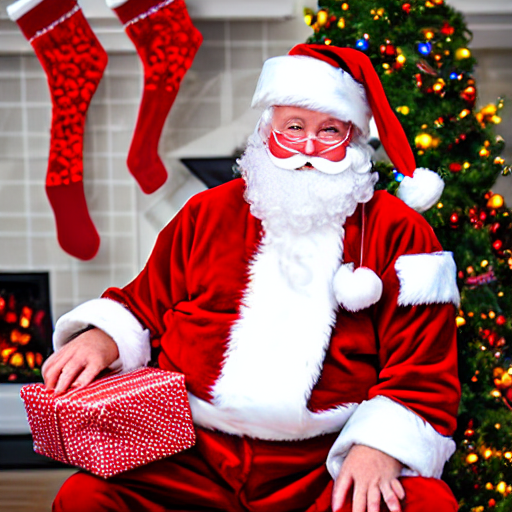

In [ ]:
inverter.generate(prompt="Santa with presents", seed=8, dg=dg)

<ipython-input-5-80c63802cddc>:40: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, self.unet.in_channels, height // 8, width // 8),
50it [00:21,  2.35it/s]


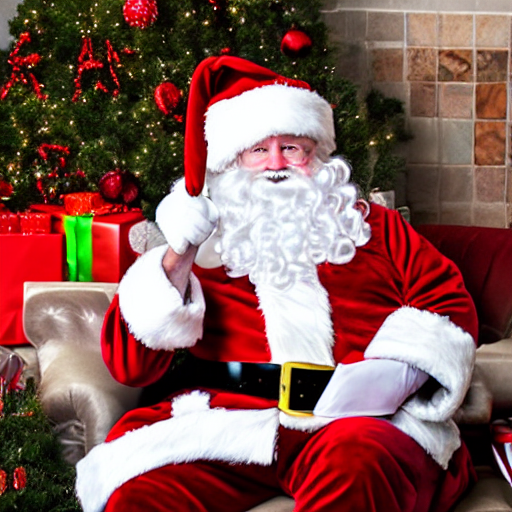

In [ ]:
inverter.generate(prompt="Santa with presents", seed=15, dg=dg)

What a disturbing Coca Cola ad.

Now, let's try swapping in our concepts. This will require us to update our TextualInversion.generate() function to include our logic for replacing the embedding. We'll do this by passing a `concept` and `target_id` argument like so:


In [7]:
class TextualInversion(TextualInversion):
  def generate(
      self, 
      prompt, 
      height=512, 
      width=512,
      num_inference_steps=50,
      guidance_scale=7.5,
      seed=8,
      batch_size=1,
      dg=None,
      concept=None,
      target_id=None
      ):
        generator = torch.manual_seed(seed)

        text_inputs = self.tokenizer(
            prompt, 
            padding="max_length", 
            max_length=self.tokenizer.model_max_length, 
            truncation=True, 
            return_tensors="pt"
        )

        text_input_ids = text_inputs.input_ids.to(self.device)
        max_length = text_inputs.input_ids.shape[-1]

        token_embeddings = self.token_embedding_layer(text_input_ids)

        if concept is not None and target_id is not None:
          replacement_embedding = concept.to(self.device)
          target_embedding = self.token_embedding_layer(torch.tensor([target_id]).to(self.device))
          token_embeddings[0, torch.where(text_input_ids[0] == target_id)] = (replacement_embedding + target_embedding)


        input_embeddings = token_embeddings + self.position_embeddings
        output_embeddings = self.get_output_embeddings(input_embeddings)

        uncond_input = self.tokenizer(
          [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, output_embeddings])

        self.scheduler.set_timesteps(num_inference_steps)

        noiseless_latents = torch.randn(
          (batch_size, self.unet.in_channels, height // 8, width // 8),
          generator=generator,
        )
        latents = noiseless_latents.to(self.device)
        latents = latents * self.scheduler.init_noise_sigma

        for i, t in tqdm(enumerate(self.scheduler.timesteps)):
            latent_model_input = torch.cat([latents] * 2)
            sigma = self.scheduler.sigmas[i]
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            unguided_noise_residual = noise_pred
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # Generate image from output latents
        with torch.no_grad():
            image = self.vae.decode((1 / 0.18215) * latents).sample # Scaling


        # Adapted from https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L441
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        image = Image.fromarray(images[0])
        
        # If we've included a Kangas DataGrid, log the generation as a row
        if dg is not None:
          dg.extend([{ 
              "prompt": prompt,
              "concept": kangas.Tensor(concept.cpu().numpy().tolist()),
              "target_id": target_id,
              "num_inference_steps": num_inference_steps,
              "guidance_scale": guidance_scale,
              "height": 512,
              "width": 512,
              "guidance_scale": guidance_scale,
              "latents": kangas.Tensor(latents.cpu().numpy().tolist()),
              "latent_model_input": kangas.Tensor(latent_model_input.cpu().numpy().tolist()),
              "unguided_noise_residual": kangas.Tensor(unguided_noise_residual.cpu().numpy().tolist()),
              "noise_pred": kangas.Tensor(noise_pred.cpu().numpy().tolist()),
              "sigma": sigma,
              "output_image": image,
              "seed": seed,
              "height": height,
              "width": width
          }])


        return image


In [14]:
inverter = TextualInversion(device=torch_device)

concepts =  [
    'Obama',
    'alf',
    'babs_bunny',
    'cat-toy',
    'charmanderanime',
    'kirby',
    'waffle-photo'
]

for concept_name in concepts:
  concept_embed = torch.load(f"./concepts/{concept_name}.bin")[f"<{concept_name}>"]
  image = inverter.generate(prompt="Santa with presents", concept=concept_embed, target_id=4555, dg=dg)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.15.layer_norm2.bias', 

Now, we can view our outputs from within the Kangas UI by running dg.show()

In [16]:
dg.show()

<IPython.core.display.Javascript object>

Alright, so replacing the embedding wholesale doesn't get us where want. Intuitively, this makes sense. We're replacing the entire concept of Santa from the embedding layer, and so none of the Santa-related details we'd hope for will be preserved. Although, I must say, there is something compelling about the waffle: 



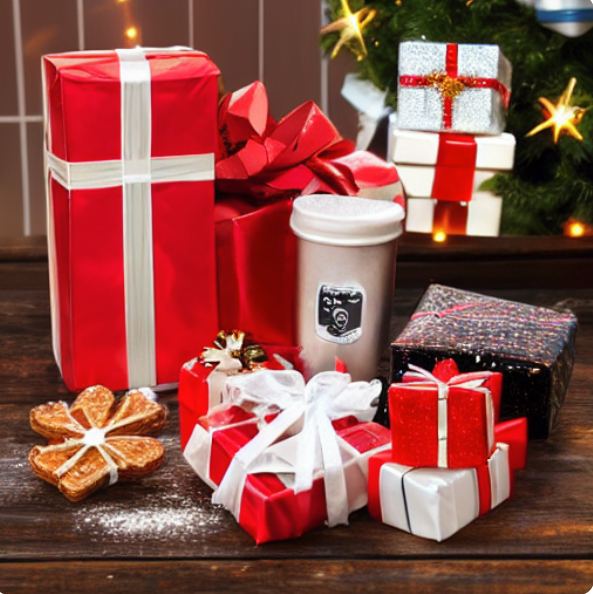

We don't want the model to completely throw out its concept of Santa—we want it to blend our concepts together.

To achieve this, I included the concept_weight parameter in our generate() function. It allows us to specify how much of the new embedding the model should use versus how much of the old embedding. If we set concept_weight to 1.0, we will only see the new embedding, as above. If we set it to 0.0, we will see the original embedding exclusively.

In [ ]:
class TextualInversion(TextualInversion):
  def generate(
      self, 
      prompt, 
      height=512, 
      width=512,
      num_inference_steps=50,
      guidance_scale=7.5,
      seed=8,
      batch_size=1,
      dg=None,
      concept=None,
      target_id=None,
      concept_weight=1.0
      ):
        generator = torch.manual_seed(seed)

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        text_input_ids = text_inputs.input_ids.to(self.device)
        max_length = text_inputs.input_ids.shape[-1]

        token_embeddings = self.token_embedding_layer(text_input_ids)

        if concept is not None and target_id is not None:
          replacement_embedding = concept.to(self.device)
          target_embedding = self.token_embedding_layer(torch.tensor([target_id]).to(self.device))
          token_embeddings[0, torch.where(text_input_ids[0] == target_id)] = ((replacement_embedding * concept_weight) + (target_embedding * (1 - concept_weight)))


        input_embeddings = token_embeddings + self.position_embeddings
        output_embeddings = self.get_output_embeddings(input_embeddings)

        uncond_input = self.tokenizer(
          [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0] 
        text_embeddings = torch.cat([uncond_embeddings, output_embeddings])

        self.scheduler.set_timesteps(num_inference_steps)

        noiseless_latents = torch.randn(
          (batch_size, self.unet.in_channels, height // 8, width // 8),
          generator=generator,
        )
        latents = noiseless_latents.to(self.device)
        latents = latents * self.scheduler.init_noise_sigma

        for i, t in tqdm(enumerate(self.scheduler.timesteps)):
            latent_model_input = torch.cat([latents] * 2)
            sigma = self.scheduler.sigmas[i]
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            with torch.no_grad():
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            unguided_noise_residual = noise_pred
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # Generate image from output latents
        with torch.no_grad():
            image = self.vae.decode((1 / 0.18215) * latents).sample # Scaling


        # Adapted from https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L441
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        image = Image.fromarray(images[0])
        
        # If we've included a Kangas DataGrid, log the generation as a row
        if dg is not None:
          dg.extend([{ 
              "prompt": prompt,
              "concept": kangas.Tensor(concept.cpu().numpy().tolist()),
              "target_id": target_id,
              "num_inference_steps": num_inference_steps,
              "guidance_scale": guidance_scale,
              "height": 512,
              "width": 512,
              "guidance_scale": guidance_scale,
              "latents": kangas.Tensor(latents.cpu().numpy().tolist()),
              "latent_model_input": kangas.Tensor(latent_model_input.cpu().numpy().tolist()),
              "unguided_noise_residual": kangas.Tensor(unguided_noise_residual.cpu().numpy().tolist()),
              "noise_pred": kangas.Tensor(noise_pred.cpu().numpy().tolist()),
              "sigma": sigma,
              "output_image": image,
              "seed": seed,
              "height": height,
              "width": width,
              "concept_weight": concept_weight
          }])

        return image


We'll try a range of values, and see what works best (this will take a few minutes):

In [ ]:
inverter = TextualInversion(device=torch_device)
dg = kangas.DataGrid(name="generated_images_weighted")
for concept_name in concepts:
  concept_embed = torch.load(f"{concept_name}.bin")[f"<{concept_name}>"]
  for weight in [0.8625, 0.75, 0.6125, 0.5, 0.375, 0.25, 0.125]:
    inverter.generate(prompt="Santa with presents", concept=concept_embed, concept_weight=weight, target_id=4555, dg=dg)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.2.layer_norm2.weight', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.17.mlp.fc1.weight', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.5.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.10.layer_norm1.

In [15]:
dg.show()

<IPython.core.display.Javascript object>

Now, we can group by concept or filter by parameters and explore our outputs. If we wanted to, we could even do a simple grid search over parameters like guidance scale or inference steps and similarly compare their results within our DataGrid.

## Picking Our New Santa Clause

Now, all that it left to do is pick our winner....

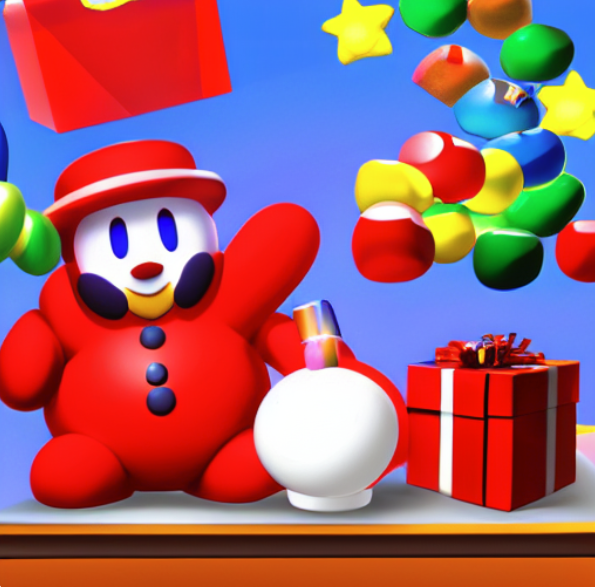

Kirby!

This is pretty great, but I think we can do better. In my next post, I'm going to try out some different approaches to this same problem and see if we can't get a better Santa. If you're curious about Kangas, [take a look at our other notebooks!](https://github.com/comet-ml/kangas/tree/main/notebooks)!